#0. Setting all up

First of all, we need to set up all the libraries and information we may need to work with, meaning we import all needed libraries now

In [45]:
from google.colab import output, files
from io import StringIO
import pandas as pd

#emoji library
!pip install emoji
import emoji

#spelling correction and contractions
!pip install contractions
!pip install textblob


import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("all")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

After this is done, we need to import the dataset we're going to be working with. 
We must take into account changes had to be made to the original dataset to correct some human mistakes made when creating it. Such as removing certain characters and ensuring the splitting is done correctly.
A new file: productsmod.csv is created.

In [46]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [57]:
import re

with open('products.csv') as f:
    products = f.read()

products = re.sub(r'"', '', products) #removing "
products = re.sub(r';', '', products) #removing ;

buf = [products.split("\n")[0]]

#correct splitting of the values
for line in products.split("\n")[1:]:
  while line.count(',') > 9:
    line = ''.join(line.rsplit(",", 1))
  buf.append("\n" + line) 
products_fix = ''.join(buf)

with open('productsmod.csv', 'w') as f:
  f.write(products_fix)

df = pd.read_csv("productsmod.csv", index_col="Id")

#display of results head
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,Natalia Corres Natalia Corres,1,1,4,1219017600,Delight says it all,This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,Michael D. Bigham M. Wassir,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


After all the data is contained into the dataframe successfully, we're filtering the columns needed. We just need the Id's, Summaries and Texts for the preprocessing, and the scores for the training part later.

In [58]:
df_products = df[['Summary', 'Text', 'Score']]
df_products.head()

,Summary,Text,Score
Id,,,
1,Good Quality Dog Food,I have bought several of the Vitality canned d...,5
2,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
3,Delight says it all,This is a confection that has been around a fe...,4
4,Cough Medicine,If you are looking for the secret ingredient i...,2
5,Great taffy,Great taffy at a great price. There was a wid...,5


#1. Pre-processing

Since we have our dataset, we need to pre-process all the information correctly. We're going to do it step by step as it will be easier to understand the steps.

We also made some extra functions to optimize code repetitions avoiding them, such as getters and setters for the fields summary and text

In [59]:
def get_summary():
  return df_products['Summary'].tolist()

def get_text():
  return df_products['Text'].tolist()

def set_summary(new_values):
  df_products.loc[:, 'Summary'] = new_values

def set_text(new_values):
  df_products.loc[:, 'Text'] = new_values

##1.1 Removing useless characters

We can define a utility function that takes into account needed characters, to then remove them from the dataset.

In [61]:
useless = "!\"$%&/()=_ˆ¡@"

def remove_useless_characters(line):
  return ''.join(char for char in str(line) if char not in useless)

summary_values = get_summary()
text_values = get_text()

summary_values_after = [remove_useless_characters(entry) for entry in summary_values]
set_summary(summary_values_after)

text_values_after= [remove_useless_characters(entry) for entry in text_values]
set_text(text_values_after)

df_products.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,Summary,Text,Score
Id,,,
1,Good Quality Dog Food,I have bought several of the Vitality canned d...,5
2,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
3,Delight says it all,This is a confection that has been around a fe...,4
4,Cough Medicine,If you are looking for the secret ingredient i...,2
5,Great taffy,Great taffy at a great price. There was a wid...,5


##1.2 Replacing capital letters

Easily done by using the function .lower(), native in Python itself

In [62]:
summary_values = get_summary()
text_values = get_text()

summary_values_after = [entry.lower() for entry in summary_values]
set_summary(summary_values_after)

text_values_after = [entry.lower() for entry in text_values]
set_text(text_values_after)

df_products.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,Summary,Text,Score
Id,,,
1,good quality dog food,i have bought several of the vitality canned d...,5
2,not as advertised,product arrived labeled as jumbo salted peanut...,1
3,delight says it all,this is a confection that has been around a fe...,4
4,cough medicine,if you are looking for the secret ingredient i...,2
5,great taffy,great taffy at a great price. there was a wid...,5


##1.3 Removing contractions

For this, we will remove only the contractions indicated in the added reference to the project. After that, we create functions to apply the patterns properly and work with the functions as we have previously.

In [63]:
patrones=[  # (patron/regex, no_contraido)
(r'isn\'t','is not'),            #isn't
(r'they\'re','they are'),        #they're
(r'wasn\'t','was not'),          # wasn't
(r'weren\'t', 'were not'),       # weren't
(r'doesn\'t','does not'),        # doesn't
(r'don\'t', 'do not'),           # don't
(r'didn\'t','did not'),          # didn't
(r'hasn\'t', 'has not'),         # hasn't
(r'we\'ve','we have'),           # we've
(r'hadn\'t', 'had not'),         # hadn't
(r'won\'t','will not'),          # won't
(r'i\'d', 'i would'),            # i'd
(r'can\'t','can not'),           # can't
(r'couldn\'t', 'could not'),     # couldn't
(r'shouldn\'t','should not'),    # shouldn't
(r'mustn\'t', 'must not'),       # mustn't
(r'might\'ve','might have'),     # might've
(r'i\'ll', 'i will')             # i'll
]
patrones = [(re.compile(regex), no_contraido) for (regex, no_contraido) in patrones]


def single_contraction(entry):
  for (regex, no_contraido) in patrones: 
    (s, count) = re.subn(regex, no_contraido, entry)
    if count > 0: 
      return s
  return entry

def contractions(entry):
  linea_out = single_contraction(entry)
  if (entry != linea_out):  
    return single_contraction(linea_out)
  else:
    return linea_out


summary_values = get_summary()
text_values = get_text()

summary_values_after = [contractions(entry) for entry in summary_values]
set_summary(summary_values_after)

text_values_after = [contractions(entry) for entry in text_values]
set_text(text_values_after)

df_products.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,Summary,Text,Score
Id,,,
1,good quality dog food,i have bought several of the vitality canned d...,5
2,not as advertised,product arrived labeled as jumbo salted peanut...,1
3,delight says it all,this is a confection that has been around a fe...,4
4,cough medicine,if you are looking for the secret ingredient i...,2
5,great taffy,great taffy at a great price. there was a wid...,5


##1.4 Removing repeated words

The method is in charge of going through each entry taking out any repeated word one by one until no repetitions are left.

In [64]:
def remove_dupes(entry): 
  linea_out = re
  expression = re.compile(r'\b(\w+)\s+\1\b')
  sub_term = r'\1'
  linea_out = expression.sub(sub_term, entry)
  if linea_out != entry: 
      return remove_dupes(linea_out) 
  else:
      return linea_out 


summary_values = get_summary()
text_values = get_text()

summary_values_after = [remove_dupes(entry) for entry in summary_values]
set_summary(summary_values_after)

text_values_after = [remove_dupes(entry) for entry in text_values]
set_text(text_values_after)

df_products.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,Summary,Text,Score
Id,,,
1,good quality dog food,i have bought several of the vitality canned d...,5
2,not as advertised,product arrived labeled as jumbo salted peanut...,1
3,delight says it all,this is a confection that has been around a fe...,4
4,cough medicine,if you are looking for the secret ingredient i...,2
5,great taffy,great taffy at a great price. there was a wid...,5


##1.5 Removing emoticons

Thanks to the function .is_emoji, we can create a method to search if a character is an emoticon.

In [65]:
def remove_emoticon(entry):
  return ''.join(char for char in str(entry) if not emoji.is_emoji(char))


summary_values = get_summary()
text_values = get_text()

summary_values_after = [remove_emoticon(entry) for entry in summary_values]
set_summary(summary_values_after)

text_values_after = [remove_emoticon(entry) for entry in text_values]
set_text(text_values_after)

df_products.head() 

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,Summary,Text,Score
Id,,,
1,good quality dog food,i have bought several of the vitality canned d...,5
2,not as advertised,product arrived labeled as jumbo salted peanut...,1
3,delight says it all,this is a confection that has been around a fe...,4
4,cough medicine,if you are looking for the secret ingredient i...,2
5,great taffy,great taffy at a great price. there was a wid...,5


##1.6 Lemmatizing terms

For the lemmatization, we can use a tool included in the ntlk library, it being WordNetLemmatizer. Since we are working with the columns of summary and text by separate, it is recommended to do it with a function as we did before, just applying it to each value in each column individually

In [66]:
lemmatizer = WordNetLemmatizer()

#lemmatizer function
def lemmatize(line):
  lemmatized_words = [lemmatizer.lemmatize(word) for word in line.split(" ")]
  return " ".join(lemmatized_words)

#function use
summary_values = get_summary()
text_values = get_text()

summary_values_after = [lemmatize(str(entry)) for entry in summary_values]
set_summary(summary_values_after)

text_values_after = [str(lemmatize(str(entry))) for entry in text_values]
set_text(text_values_after)

df_products.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,Summary,Text,Score
Id,,,
1,good quality dog food,i have bought several of the vitality canned d...,5
2,not a advertised,product arrived labeled a jumbo salted peanuts...,1
3,delight say it all,this is a confection that ha been around a few...,4
4,cough medicine,if you are looking for the secret ingredient i...,2
5,great taffy,great taffy at a great price. there wa a wide...,5


#2. Vectorization

Firstly, we need to clean some data to improve the proccess itself, we create a value Summary_text which helps us by joining both of said values into one.

In [70]:
df_products['Summary_text'] = [str(df_products.iloc[i].Summary) + ' ' + df_products.iloc[i].Text for i in range(len(df_products))]
df_products = df_products[df_products['Score'].isin(['1','2','3','4','5'])]

df_products.reset_index(drop = True, inplace = True)

df_products.head()

,Summary,Text,Score,Summary_text
0,good quality dog food,i have bought several of the vitality canned d...,5,good quality dog food i have bought several of...
1,not a advertised,product arrived labeled a jumbo salted peanuts...,1,not a advertised product arrived labeled a jum...
2,delight say it all,this is a confection that ha been around a few...,4,delight say it all this is a confection that h...
3,cough medicine,if you are looking for the secret ingredient i...,2,cough medicine if you are looking for the secr...
4,great taffy,great taffy at a great price. there wa a wide...,5,great taffy great taffy at a great price. the...


Now that our dataframe has been completely processed, we can proceed with the following steps.

##2.1 TFIDF

We must also make notice about limiting the number of revies to 1500 in order to optimize the process and avoid overheating.

In [77]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

summary_text_tfidf = df_products['Summary_text'][:1500].tolist()
scores_tfidf = df_products['Score'][:1500].tolist()
scores_int_tfidf = np.array([int(x) for x in scores_tfidf])

tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
vectors_tfidf = tfidf_vectorizer.fit_transform(summary_text_tfidf)
df_vectors_tfidf = pd.DataFrame(vectors_tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names())

df_vectors_tfidf

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,03,042608460503,0472066978,0738551856,09,0g,0mg,0z,10,...,zesty,zevia,zinc,zing,zip,zippy,zola,zucchini,zukes,ît
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##2.2 TFIDF + N-grams

We apply a range in order to keep things light when processing

In [76]:
tfidf_ngrams_vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors_tfidf_ngrams = tfidf_ngrams_vectorizer.fit_transform(summary_text_tfidf)
df_vectors_tfidf_ngrams = pd.DataFrame(vectors_tfidf_ngrams.toarray(), columns = tfidf_ngrams_vectorizer.get_feature_names())

df_vectors_tfidf_ngrams

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,00 bag,00 car,00 case,00 diamond,00 flour,00 for,00 later,00 more,00 naturally,...,zucchini,zucchini and,zucchini asparagus,zucchini br,zucchini brown,zucchini organic,zukes,zukes just,ît,ît real
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##2.3 TFIDF + N-grams + POS Tagging

In [79]:
from nltk.tokenize import word_tokenize
tags = {}

for column in df_vectors_tfidf_ngrams.columns:
  ngram = word_tokenize(column)
  column_tags = nltk.pos_tag(ngram)
  if len(column.split()) == 1:
    tags.update({column:column_tags[0][1]})

df_vectors_tfidf_ngrams_postag = df_vectors_tfidf_ngrams.copy()

num_adjectives = []

for i in range(1500):
  words = summary_text_tfidf[i].split()
  adj_counter = 0
  for word in words:
    if word in tags.keys():
      if tags[word] == 'JJ':
        adj_counter += 1
  num_adjectives.append(adj_counter)

df_vectors_tfidf_ngrams_postag['num_adjectives'] = num_adjectives
df_vectors_tfidf_ngrams_postag

,00,00 bag,00 car,00 case,00 diamond,00 flour,00 for,00 later,00 more,00 naturally,...,zucchini and,zucchini asparagus,zucchini br,zucchini brown,zucchini organic,zukes,zukes just,ît,ît real,num_adjectives
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


##2.4 TFIDF + N-grams + POS Tagging + Other features

In [80]:
df_vectors_tfidf_ngrams_postag_other = df_vectors_tfidf_ngrams_postag.copy()

num_words = []
num_sentences = []

for i in range(len(summary_text_tfidf)):
  num_words.append(len(summary_text_tfidf[i].split()))
  num_sentences.append(len(summary_text_tfidf[i].split('. ')))

df_vectors_tfidf_ngrams_postag_other['num_words'] = num_words
df_vectors_tfidf_ngrams_postag_other['num_sentences'] = num_sentences
df_vectors_tfidf_ngrams_postag_other

,00,00 bag,00 car,00 case,00 diamond,00 flour,00 for,00 later,00 more,00 naturally,...,zucchini br,zucchini brown,zucchini organic,zukes,zukes just,ît,ît real,num_adjectives,num_words,num_sentences
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,52,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,34,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,98,8
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,43,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,271,18
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,136,7
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,126,9
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,42,4


#3. Feature selection

For the feature selection, we are going to apply the selectKBest method and will remove 70% of the features used.

##3.1 For TFIDF

In [83]:
from sklearn.feature_selection import SelectKBest, chi2

reduced_df_vectors_tfidf = SelectKBest(score_func = chi2, k = int(len(df_vectors_tfidf.columns) * 0.3)).fit_transform(df_vectors_tfidf, scores_int_tfidf)

df_tfidf = pd.DataFrame(reduced_df_vectors_tfidf)
df_tfidf['score'] = scores_int_tfidf
df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,2219,2220,2221,2222,2223,2224,2225,2226,2227,score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


##3.2 For TFIDF + N-grams

In [85]:
df_vectors_tfidf_ngrams_fr = df_vectors_tfidf_ngrams.loc[:, df_vectors_tfidf_ngrams.columns != "score"]
df_vectors_tfidf_ngrams_fr = df_vectors_tfidf_ngrams_fr.loc[:, df_vectors_tfidf_ngrams_fr.columns != "num_words"]
df_vectors_tfidf_ngrams_fr = df_vectors_tfidf_ngrams_fr.loc[:, df_vectors_tfidf_ngrams_fr.columns != "num_sentences"]
df_vectors_tfidf_ngrams_fr = df_vectors_tfidf_ngrams_fr.loc[:, df_vectors_tfidf_ngrams_fr.columns != "num_adjectives"]

reduced_df_vectors_tfidf_ngrams = SelectKBest(score_func = chi2, k = int(len(df_vectors_tfidf_ngrams_fr.columns) * 0.3)).fit_transform(df_vectors_tfidf_ngrams_fr, scores_int_tfidf)

df_tfidf_ngrams = pd.DataFrame(reduced_df_vectors_tfidf_ngrams)
df_tfidf_ngrams['score'] = scores_int_tfidf
df_tfidf_ngrams

,0,1,2,3,4,5,6,7,8,9,...,18403,18404,18405,18406,18407,18408,18409,18410,18411,score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


##3.3 For TFIDF + N-grams + POS Tagging

In [92]:
df_vectors_tfidf_ngrams_postag.drop(columns = ['Score', 'num_words', 'num_sentences', 'num_adjectives'], inplace = True, errors = 'ignore')

reduced_df_vectors_tfidf_ngrams_postag = SelectKBest(score_func = chi2, k = int(len(df_vectors_tfidf_ngrams_postag.columns) * 0.3)).fit_transform(df_vectors_tfidf_ngrams_postag, scores_int_tfidf)
reduced_df_vectors_tfidf_ngrams_postag

min_max_scaler = preprocessing.MinMaxScaler()

df_tfidf_ngrams_postag = pd.DataFrame(reduced_df_vectors_tfidf_ngrams_postag)
df_tfidf_ngrams_postag['num_adjectives'] = num_adjectives
df_tfidf_ngrams_postag['score'] = scores_int_tfidf

df_tfidf_ngrams_postag['num_adjectives'] = min_max_scaler.fit_transform(df_tfidf_ngrams_postag[['num_adjectives']])

df_tfidf_ngrams_postag

,0,1,2,3,4,5,6,7,8,9,...,18404,18405,18406,18407,18408,18409,18410,18411,num_adjectives,score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038961,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025974,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051948,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012987,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051948,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194805,5
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064935,5
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,5
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025974,5


##3.4 For TFIDF + N-grams + POS Tagging + Other features

In [91]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

df_vectors_tfidf_ngrams_postag_other.drop(columns = ['Score', 'num_words', 'num_sentences', 'num_adjectives'], inplace = True, errors = 'ignore')

reduced_df_vectors_tfidf_ngrams_postag_other = SelectKBest(score_func = chi2, k = int(len(df_vectors_tfidf_ngrams_postag_other.columns) * 0.3)).fit_transform(df_vectors_tfidf_ngrams_postag_other, scores_int_tfidf)

df_tfidf_ngrams_postag_other = pd.DataFrame(reduced_df_vectors_tfidf_ngrams_postag_other)
df_tfidf_ngrams_postag_other['num_words'] = num_words
df_tfidf_ngrams_postag_other['num_sentences'] = num_sentences
df_tfidf_ngrams_postag_other['num_adjectives'] = num_adjectives
df_tfidf_ngrams_postag_other['score'] = scores_int_tfidf

df_tfidf_ngrams_postag_other['num_adjectives'] = min_max_scaler.fit_transform(df_tfidf_ngrams_postag_other[['num_adjectives']])
df_tfidf_ngrams_postag_other['num_sentences'] = min_max_scaler.fit_transform(df_tfidf_ngrams_postag_other[['num_sentences']])
df_tfidf_ngrams_postag_other['num_words'] = min_max_scaler.fit_transform(df_tfidf_ngrams_postag_other[['num_words']])

df_tfidf_ngrams_postag_other

,0,1,2,3,4,5,6,7,8,9,...,18406,18407,18408,18409,18410,18411,num_words,num_sentences,num_adjectives,score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.039430,0.06250,0.038961,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.019715,0.03125,0.025974,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.089814,0.21875,0.051948,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.029573,0.06250,0.012987,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.014239,0.09375,0.051948,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.279299,0.53125,0.194805,5
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.131435,0.18750,0.064935,5
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.120482,0.25000,0.090909,5
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.028478,0.09375,0.025974,5


#4. Classification Algorithm

Lastly, since we have our features selected, we can procceed to classify the opinions. All should be made having into account the field "score" and having 70% of the values for training and the rest for testing. All algorithms are made with Support Vector Machines

##4.1 For TFIDF

We divide the values into train and test to proceed

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_tfidf.drop(columns = ['score']), df_tfidf.score, random_state = 1, train_size = 0.7)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


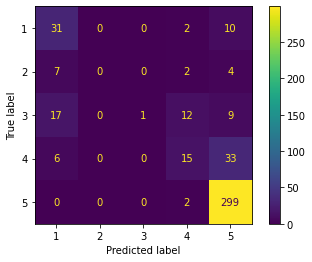

In [99]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
!pip install tabulate
from tabulate import tabulate

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

##4.2 For TF-IDF with n-grams

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_tfidf_ngrams.drop(columns = ['score']), df_tfidf_ngrams.score, random_state = 1, train_size = 0.7)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


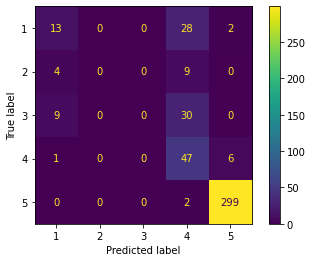

In [108]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
!pip install tabulate
from tabulate import tabulate

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

##4.3 For TF-IDF n-grams with POS-tagging

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_tfidf_ngrams_postag.drop(columns = ['score']), df_tfidf_ngrams_postag.score, random_state = 1, train_size = 0.7)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


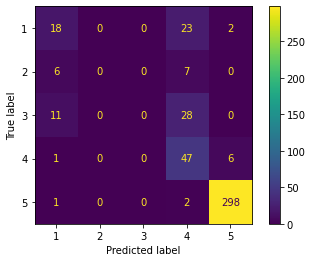

In [110]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
!pip install tabulate
from tabulate import tabulate

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()


##4.4 For TF-IDF n-grams with POS-tagging and additional features

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_tfidf_ngrams_postag_other.drop(columns = ['score']), df_tfidf_ngrams_postag_other.score, random_state = 1, train_size = 0.7)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


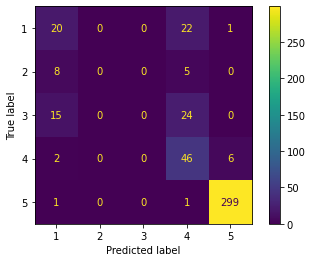

In [112]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
!pip install tabulate
from tabulate import tabulate

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()